In [2]:
import sys
sys.path.append('../')
from SynRBL.rsmi_utils import *
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from SynRBL.rsmi_utils import load_database, filter_data
reactions_clean = load_database('../Data/reaction_clean.json.gz')
filtered_data_1 = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], formula_key='Diff_formula', element_key='C', min_count=1, max_count=10000)
len(filtered_data_1)

13752

In [3]:
filtered_data_2 = filter_data(reactions_clean, unbalance_values=['Both'], formula_key='Diff_formula', element_key='C', min_count=0, max_count=10000)
len(filtered_data_2)

3088

In [4]:
filtered_data = filtered_data_1 + filtered_data_2
len(filtered_data)

16840

In [5]:
from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem import rdFMCS

class MCSMissingGraphAnalyzer:
    """A class for detecting missing graph in reactants and products using MCS and RDKit."""

    def __init__(self):
        """Initialize the MolecularOperations class."""
        pass
    
    @staticmethod
    def get_smiles(reaction_dict):
        """
        Extract reactant and product SMILES strings from a reaction dictionary.

        Parameters:
        - reaction_dict: dict
            A dictionary containing 'reactants' and 'products' as keys.

        Returns:
        - tuple
            A tuple containing reactant SMILES and product SMILES strings.
        """
        return reaction_dict['reactants'], reaction_dict['products']

    @staticmethod
    def convert_smiles_to_molecule(smiles):
        """
        Convert a SMILES string to an RDKit molecule object.

        Parameters:
        - smiles: str
            The SMILES string representing a molecule.

        Returns:
        - rdkit.Chem.Mol
            The RDKit molecule object.
        """
        return Chem.MolFromSmiles(smiles)

    @staticmethod
    def mol_to_smiles(mol):
        """
        Convert an RDKit molecule object to a SMILES string.

        Parameters:
        - mol: rdkit.Chem.Mol
            The RDKit molecule object.

        Returns:
        - str or None
            The SMILES string representation of the molecule, or None if the molecule is None.
        """
        return Chem.MolToSmiles(mol) if mol else None

    @staticmethod
    def mol_to_smarts(mol):
        """
        Convert an RDKit molecule object to a SMARTS string.

        Parameters:
        - mol: rdkit.Chem.Mol
            The RDKit molecule object.

        Returns:
        - str or None
            The SMARTS string representation of the molecule, or None if the molecule is None.
        """
        return Chem.MolToSmarts(mol) if mol else None

    @staticmethod
    def find_maximum_common_substructure(mol1, mol2, ringMatchesRingOnly=True):
        """
        Find the maximum common substructure (MCS) between two molecules.

        Parameters:
        - mol1, mol2: rdkit.Chem.Mol
            The RDKit molecule objects to compare.

        Returns:
        - rdkit.Chem.Mol or None
            The RDKit molecule object representing the MCS, or None if MCS search was canceled.
        """
        mcs_result = rdFMCS.FindMCS([mol1, mol2], ringMatchesRingOnly=ringMatchesRingOnly)
        if mcs_result.canceled:
            return None
        mcs_mol = Chem.MolFromSmarts(mcs_result.smartsString)
        return mcs_mol

    def IterativeMCSReactionPairs(reactant_mol_list, product_mol, params=None):
        """
        Find the MCS for each reactant fragment with the product, updating the product after each step.
        Sorts the reactants based on the size of their MCS with the product.

        Parameters:
        - reactant_mol_list: list of rdkit.Chem.Mol
            List of RDKit molecule objects for reactants.
        - product_mol: rdkit.Chem.Mol
            RDKit molecule object for the product.

        Returns:
        - list of rdkit.Chem.Mol
            List of RDKit molecule objects representing the MCS for each reactant-product pair.
        - list of rdkit.Chem.Mol
            Sorted list of reactant molecule objects.
        """
        # Calculate the MCS for each reactant with the product
        mcs_results = [(reactant, rdFMCS.FindMCS([reactant, product_mol], params)) for reactant in reactant_mol_list]

        # Filter out any canceled MCS results and sort by size of MCS
        mcs_results = [(reactant, mcs_result) for reactant, mcs_result in mcs_results if not mcs_result.canceled]
        sorted_reactants = sorted(mcs_results, key=lambda x: x[1].numAtoms, reverse=True)

        mcs_list = []
        current_product = product_mol

        # Process the sorted reactants
        for reactant, mcs_result in sorted_reactants:
            mcs_mol = Chem.MolFromSmarts(mcs_result.smartsString)
            mcs_list.append(mcs_mol)

            # Update the product by removing the MCS substructure
            current_product = Chem.DeleteSubstructs(Chem.RWMol(current_product), mcs_mol)
            current_product = Chem.RemoveHs(current_product)
            try:
                Chem.SanitizeMol(current_product)
            except:
                pass

        # Extract only the reactant molecules from sorted_reactants for return
        sorted_reactant_mols = [reactant for reactant, _ in sorted_reactants]

        return mcs_list, sorted_reactant_mols

    
    @staticmethod
    def add_hydrogens_to_radicals(mol):
        """
        Add hydrogen atoms to radical sites in a molecule.

        Parameters:
        - mol: rdkit.Chem.Mol
            RDKit molecule object.

        Returns:
        - rdkit.Chem.Mol
            The modified molecule with added hydrogens.
        """
        if mol:
            # Create a copy of the molecule
            mol_with_h = Chem.RWMol(mol)

            # Add explicit hydrogens (not necessary if they are already present in the input molecule)
            mol_with_h = rdmolops.AddHs(mol_with_h)

            # Find and process radical atoms
            for atom in mol_with_h.GetAtoms():
                num_radical_electrons = atom.GetNumRadicalElectrons()
                if num_radical_electrons > 0:
                    atom.SetNumExplicitHs(atom.GetNumExplicitHs() + num_radical_electrons)
                    atom.SetNumRadicalElectrons(0)
            curate_mol = Chem.RemoveHs(mol_with_h)
            # Return the molecule with added hydrogens
            return curate_mol

    @staticmethod
    def fit(reaction_dict, params=None):
        """
        Process a reaction dictionary to find MCS, missing parts in reactants and products.

        Parameters:
        - reaction_dict: dict
            A dictionary containing 'reactants' and 'products' as keys.

        Returns:
        - tuple
            A tuple containing lists of MCS, missing parts in reactants, missing parts in products,
            reactant molecules, and product molecules.
        """
        reactant_smiles, product_smiles = MCSMissingGraphAnalyzer.get_smiles(reaction_dict)
        reactant_mol_list = [MCSMissingGraphAnalyzer.convert_smiles_to_molecule(smiles) for smiles in reactant_smiles.split('.')]
        product_mol = MCSMissingGraphAnalyzer.convert_smiles_to_molecule(product_smiles)

        mcs_list, sorted_reactants = MCSMissingGraphAnalyzer.IterativeMCSReactionPairs(reactant_mol_list, product_mol,  params)

        return mcs_list , sorted_reactants, product_mol

In [6]:
from rdkit import Chem
def find_missing_parts_pairs(mol_list, mcs_list):
    """
    This function analyzes each molecule in a given list and identifies the parts that are not 
    present in the corresponding Maximum Common Substructure (MCS). It also finds the boundary 
    atoms and nearest neighbors for each molecule.

    Parameters:
    - mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.
    - mcs_list (list of rdkit.Chem.Mol): List of RDKit molecule objects representing MCS, 
    corresponding to each molecule in mol_list.

    Returns:
    Tuple containing:
    - list of rdkit.Chem.Mol or None: RDKit molecule objects representing the missing parts 
    of each molecule, or None if no missing parts are found.
    - list of lists: Each sublist contains the boundary atoms of the corresponding molecule.
    - list of lists: Each sublist contains the nearest neighbors of the corresponding molecule.
    """
    missing_parts_list = []
    boundary_atoms_lists = []
    nearest_neighbor_lists = []

    for mol, mcs_mol in zip(mol_list, mcs_list):
        atoms_to_remove = set()
        boundary_atoms_list = []
        nearest_neighbor_list = []

        if mcs_mol:
            # Special case handling (e.g., single oxygen atom)
            if Chem.MolToSmiles(mcs_mol) == 'O':
                smarts_pattern = '[OH]'
                smarts_mol = Chem.MolFromSmarts(smarts_pattern)
                substructure_match = mol.GetSubstructMatch(smarts_mol)
                rw_mol = Chem.RWMol(mol)
                rw_mol.RemoveAtom(substructure_match[0])
                missing_part = rw_mol.GetMol()
                boundary_atoms = [{'O': 0}]
                nearest_atoms = [{'O': 0}]
            else:
                # Finding substructure matches
                substructure_match = mol.GetSubstructMatch(mcs_mol)
                if substructure_match:
                    atoms_to_remove.update(substructure_match)

                # Creating the molecule of missing parts
                missing_part = Chem.RWMol(mol)
                for idx in sorted(atoms_to_remove, reverse=True):
                    missing_part.RemoveAtom(idx)

                # Mapping indices from original to missing part molecule
                index_mapping = {idx: i for i, idx in enumerate(sorted(set(range(mol.GetNumAtoms())) - atoms_to_remove))}

                boundary_atoms = []
                nearest_atoms = []

                # Identifying boundary atoms and nearest neighbors
                for atom_idx in substructure_match:
                    if atom_idx < mol.GetNumAtoms():
                        atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                        neighbors = mol.GetAtomWithIdx(atom_idx).GetNeighbors()
                        # Loop through neighbors to find boundary atoms and nearest neighbors
                        for neighbor in neighbors:
                            if neighbor.GetIdx() not in substructure_match:
                                nearest_atoms.append({atom_symbol: atom_idx})
                                renumerate_idx = index_mapping.get(neighbor.GetIdx(), -1)
                                if renumerate_idx != -1:
                                    boundary_atoms.append({neighbor.GetSymbol(): renumerate_idx})

            if boundary_atoms:
                boundary_atoms_list.append(boundary_atoms)
            if nearest_atoms:
                nearest_neighbor_list.append(nearest_atoms)

        try:
            Chem.SanitizeMol(missing_part)
            if missing_part.GetNumAtoms() > 0:
                missing_parts_list.append(missing_part)
                boundary_atoms_lists.extend(boundary_atoms_list)
                nearest_neighbor_lists.extend(nearest_neighbor_list)
            else:
                #missing_parts_list.append(None)
                boundary_atoms_lists.extend([])
                nearest_neighbor_lists.extend([])
        except:
            #missing_parts_list.append(None)
            boundary_atoms_lists.extend([])
            nearest_neighbor_lists.extend([])

    return missing_parts_list, boundary_atoms_lists, nearest_neighbor_lists

In [34]:
from rdkit.Chem import AllChem, rdChemReactions
#from SynRBL.SynMCS.mcs_missing_graph_analyzer import MCSMissingGraphAnalyzer
from SynRBL.SynMCS.find_missing_graphs import find_missing_parts_pairs

def display_reaction(reaction_dict, reaction_key='reactions', use_smiles=True):
    """
    Displays a chemical reaction using RDKit.

    Parameters:
    - reaction_dict: A dictionary containing reaction data.
    - reaction_key: Key to access reaction information in the dictionary.
    - use_smiles: Whether to use SMILES format for the reaction.
    """
    return rdChemReactions.ReactionFromSmarts(reaction_dict[reaction_key], useSmiles=use_smiles)



In [35]:
def single_impute(data_dict, params=None):
    """
    Performs imputation on a single reaction data entry and captures any issues encountered.

    Parameters:
    - data_dict: Dict containing reaction data.
    - params: Optional parameters for MCS analysis.

    Returns:
    - dict: A dictionary containing imputation results and any issues encountered.
    """
    from rdkit import Chem
    from SynRBL.SynMCS.mcs_missing_graph_analyzer import MCSMissingGraphAnalyzer
    from SynRBL.SynMCS.find_missing_graphs import find_missing_parts_pairs

    impute_dict = {'impute_product_smiles': [], 'boundary_atoms_products': [], 'nearest_neighbor_products': [], 'issue': []}

    try:
        analyzer = MCSMissingGraphAnalyzer()
        mcs_list, sorted_reactants, product_mol = analyzer.fit(data_dict, params=params)
        impute_product_frags, boundary_atoms_products, nearest_neighbor_products = find_missing_parts_pairs(sorted_reactants, mcs_list)
        impute_product_smiles = [Chem.MolToSmiles(impute_product) for impute_product in impute_product_frags]

        impute_dict['impute_product_smiles'] = impute_product_smiles
        impute_dict['boundary_atoms_products'] = boundary_atoms_products
        impute_dict['nearest_neighbor_products'] = nearest_neighbor_products

    except Exception as e:
        display_reaction(data_dict)
        impute_dict['issue'] = data_dict

    return impute_dict


In [36]:
final = Parallel(n_jobs=8)(delayed(single_impute)(data_dict) for data_dict in filtered_data[100:300])

[15:14:24] non-ring atom 2 marked aromatic


In [25]:
final = pd.DataFrame(final)
df = final.applymap(lambda x: np.nan if x == [] else x)

# Display the DataFrame
display(df.head())

/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_52575/3640427241.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = final.applymap(lambda x: np.nan if x == [] else x)


,impute_product_smiles,boundary_atoms_products,nearest_neighbor_products,issue
0,[O=COCc1ccccc1],[[{'C': 0}]],[[{'N': 9}]],NaN
1,"[CC1(C)OBOC1(C)C, Br]","[[{'B': 4}], [{'Br': 0}]]","[[{'C': 5}], [{'C': 13}]]",NaN
2,[CC(C)C],[[{'C': 1}]],[[{'O': 4}]],NaN
3,[COc1ccc(C)cc1],[[{'C': 0}]],[[{'N': 8}]],NaN
4,[C],[[{'C': 0}]],[[{'O': 1}]],NaN


In [29]:
df['impute_product_smiles'].isnull().sum()

0

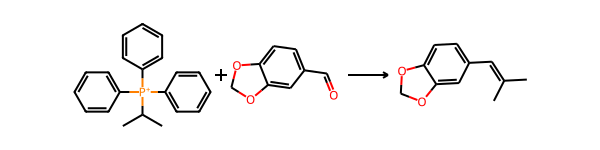

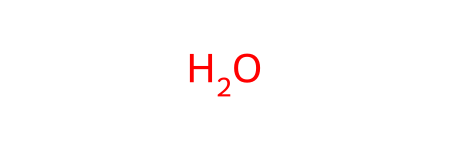

Boundary list for fragment 0 : [{'O': 0}]
Nearest neighbor list for fragment 0 : [{'C': 1}]


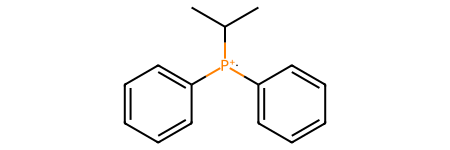

Boundary list for fragment 1 : [{'P': 3}]
Nearest neighbor list for fragment 1 : [{'C': 4}]


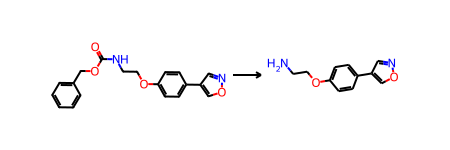

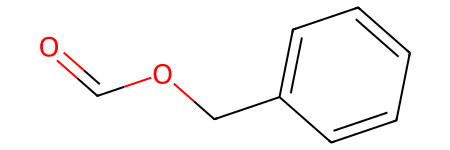

Boundary list for fragment 0 : [{'C': 1}]
Nearest neighbor list for fragment 0 : [{'N': 2}]


In [ ]:
Fail = [8]

rare = [13]